<a href="https://colab.research.google.com/github/tsangrebecca/BloomTech/blob/main/Sprint6/Module4/LS_DS_224_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

BloomTech Data Science

*Unit 2, Sprint 2, Module 4*

---

In [1]:
%%capture
!pip install category_encoders==2.*

In [2]:
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://github.com/bloominstituteoftechnology/DS-Unit-2-Kaggle-Challenge/tree/main/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

# Module Project: Classification Metrics

This sprint, the module projects will focus on creating and improving a model for the Tanazania Water Pump dataset. Your goal is to create a model to predict whether a water pump is functional, non-functional, or needs repair.

Dataset source: [DrivenData.org](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/).

## Directions

The tasks for this project are as follows:

- **Task 1:** Use `wrangle` function to import training and test data.
- **Task 2:** Split training data into feature matrix `X` and target vector `y`.
- **Task 3:** Split training data into training and validation sets.
- **Task 4:** Establish the baseline accuracy score for your dataset.
- **Task 5:** Build `model`.
- **Task 6:** Calculate the training and validation accuracy score for your model.
- **Task 7:** Plot the confusion matrix for your model.
- **Task 8:** Print the classification report for your model.
- **Task 9:** Identify likely `'non-functional'` pumps in the test set.
- **Task 10:** Find likely `'non-functional'` pumps serving biggest populations.
- **Task 11 (`stretch goal`):** Plot pump locations from Task 10.

You should limit yourself to the following libraries for this project:

- `category_encoders`
- `matplotlib`
- `pandas`
- `ydata-profiling`
- `plotly`
- `sklearn`


# I. Wrangle Data

In [3]:
def wrangle(fm_path, tv_path=None):
    if tv_path:
        df = pd.merge(pd.read_csv(fm_path,
                                  na_values=[0, -2.000000e-08]),
                      pd.read_csv(tv_path)).set_index('id')
    else:
        df = pd.read_csv(fm_path,
                         na_values=[0, -2.000000e-08],
                         index_col='id')

    # Drop constant columns
    df.drop(columns=['recorded_by'], inplace=True)

    # Drop HCCCs
    cutoff = 100
    drop_cols = [col for col in df.select_dtypes('object').columns
                 if df[col].nunique() > cutoff]
    df.drop(columns=drop_cols, inplace=True)

    # Drop duplicate columns
    dupe_cols = [col for col in df.head(15).T.duplicated().index
                 if df.head(15).T.duplicated()[col]]
    df.drop(columns=dupe_cols, inplace=True)

    return df

**Task 1:** Using the above `wrangle` function to read `train_features.csv` and `train_labels.csv` into the DataFrame `df`, and `test_features.csv` into the DataFrame `X_test`.

In [4]:
df = wrangle(fm_path='train_features.csv', tv_path = 'train_labels.csv')
X_test = wrangle(fm_path = 'test_features.csv')

In [ ]:
X_test.head()

,amount_tsh,gps_height,longitude,latitude,num_private,basin,region,region_code,district_code,population,...,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,
37098,NaN,NaN,31.985658,-3.596360,NaN,Lake Tanganyika,Shinyanga,17,5.0,NaN,...,unknown,unknown,soft,good,dry,shallow well,shallow well,groundwater,other,other
14530,NaN,NaN,32.832815,-4.944937,NaN,Lake Tanganyika,Tabora,14,6.0,NaN,...,never pay,never pay,milky,milky,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump
62607,10.0,1675.0,35.488289,-4.242048,NaN,Internal,Manyara,21,1.0,148.0,...,pay per bucket,per bucket,soft,good,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
46053,NaN,NaN,33.140828,-9.059386,NaN,Lake Rukwa,Mbeya,12,6.0,NaN,...,never pay,never pay,soft,good,seasonal,shallow well,shallow well,groundwater,hand pump,hand pump
47083,50.0,1109.0,34.217077,-4.430529,NaN,Internal,Singida,13,1.0,235.0,...,pay per bucket,per bucket,soft,good,enough,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe


# II. Split Data

**Task 2:** Split your DataFrame `df` into a feature matrix `X` and the target vector `y`. You want to predict `'status_group'`.

**Note:** You won't need to do a train-test split because you'll use cross-validation instead.

In [5]:
target = 'status_group'
y = df[target]
X = df.drop(columns=target)

**Task 3:** Using a randomized split, divide `X` and `y` into a training set (`X_train`, `y_train`) and a validation set (`X_val`, `y_val`).

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# III. Establish Baseline

**Task 4:** Since this is a **classification** problem, you should establish a baseline accuracy score. Figure out what is the majority class in `y_train` and what percentage of your training observations it represents.

In [ ]:
y_train.value_counts()

functional                 20625
non functional             14611
functional needs repair     2779
Name: status_group, dtype: int64

In [ ]:
print('Baseline Accuracy:', y_train.value_counts(normalize=True).max())

Baseline Accuracy: 0.5425489938182296


Majority Class is Functional. To find percentage of training observations, we would do: percentage = functional / len(y_train). len(y_train) gives me the total number of observations.

# IV. Build Models

**Task 5:** Build and train your `model`. Include the transformers and predictor that you think are most appropriate for this problem.

In [7]:
model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_estimators=100, max_depth=20, n_jobs=-1, random_state=42)
)

model.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity', 'source',
                                      'source_type', 'source_class',
                                      'waterpoint_type'],
                                mapping=[{'col': 'basin',
                                          'data_typ...
                                          'mapping': groundwater    1
surface        2
unknown        3
NaN           -2
dtype: int64},
                                         {'col': 'waterpoint_type',
                                          'data_type': dtype('O'),
                                          'mapping': hand pump                      1
communal standpipe             2
communal standpipe multiple    3
improved spring                4
other                          5
cattle trough                  6
dam                            7
NaN                           -2
dtype: int64}])),
                ('simpleimputer', SimpleImputer()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=20, n_jobs=-1,
                                        random_state=42))])

# V. Check Metrics

**Task 6:** Calculate the training and validation accuracy scores for `model`.

In [ ]:
print('Training Accuracy:', model.score(X_train, y_train))
print('Validation Accuracy:', model.score(X_val, y_val))

Training Accuracy: 0.9928449296330396
Validation Accuracy: 0.7896675084175084


**Task 7:** Plot the confusion matrix for your model, using your validation data.

**Note:** Since there are three classes in your target vector, the dimensions of your matrix will be 3x3.

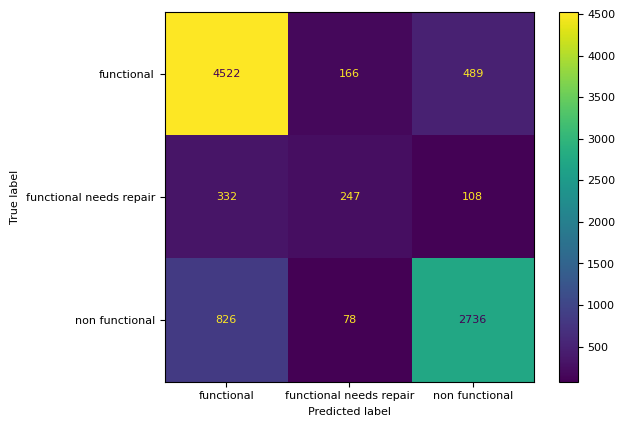

In [ ]:
# Plot 3x3 confusion matrix
ConfusionMatrixDisplay.from_estimator(
    model,
    X_val,
    y_val,
    values_format='.0f'
)

plt.rcParams['font.size'] = 5

Calculating precision and recall for a multiclass problem is a bit of a mess. Fortunately, we can use `sklearn`'s classification report.

**Task 8:**  Print the classification report for your `model`, using your validation data.

In [ ]:
# Print classification report
print(classification_report(y_val,
                      model.predict(X_val)))

                         precision    recall  f1-score   support

             functional       0.80      0.87      0.83      5177
functional needs repair       0.50      0.36      0.42       687
         non functional       0.82      0.75      0.78      3640

               accuracy                           0.79      9504
              macro avg       0.71      0.66      0.68      9504
           weighted avg       0.78      0.79      0.78      9504



# VI. Tune Model

Usually, we use this part of the ML workflow to adjust the hyperparameters of the our model to increase performance based on metrics like accuracy. Today, we'll use it to help maximize the impact of our water pump repairs when resources are scarce. What if we only had funds to repair 100 water pumps?

(This activity is based on a [post](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050) by Lambda alum Michael Brady.)

**Task 9:** Using your model's `predict_proba` method, identify the observations in your **validation set** (edited and verified by Samantha)where the model is more than 95% certain that a pump is `'non-functional'`. Put these observations in the DataFrame `X_test_nf`.

In [ ]:
# model.predict_proba(X_val) will give us 3 columns

In [9]:
# model[-1] will give us the last element in the pipeline which is the random forest classifier.
# .classes_ attribute (refer to sklearn documentation) gives you the labels to the 3 columns of arrays that were generated so we know
#    which column to grab
model[-1].classes_

array(['functional', 'functional needs repair', 'non functional'],
      dtype=object)

In [ ]:
model.predict_proba(X_val)[:,-1] # we grab the last column because we need 'non-functional'

array([0.17371235, 1.        , 0.50638035, ..., 0.80756845, 0.67729239,
       0.6625507 ])

In [ ]:
# create a dataframe with a dictionary with actualy y_val and predicted values from model
results = pd.DataFrame({'y_val': y_val,
                        'y_pred_proba': model.predict_proba(X_val)[:,-1]}) # grab the last column which is 'non-functional'

In [ ]:
threshold = 0.95
mask = (results['y_pred_proba'] > threshold)

In [ ]:
model.predict_proba(X_val)

array([[0.79570369, 0.03058396, 0.17371235],
       [0.        , 0.        , 1.        ],
       [0.41545478, 0.07816486, 0.50638035],
       ...,
       [0.15583517, 0.03659638, 0.80756845],
       [0.29400576, 0.02870186, 0.67729239],
       [0.23255316, 0.10489614, 0.6625507 ]])

In [ ]:
y_val.head()

id
8492.0     functional needs repair
16772.0             non functional
19506.0                 functional
40301.0             non functional
61519.0                 functional
Name: status_group, dtype: object

In [ ]:
X_val.head()

,amount_tsh,gps_height,longitude,latitude,num_private,basin,region,region_code,district_code,population,...,management_group,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type
id,,,,,,,,,,,,,,,,,,,,,
8492.0,NaN,876.0,37.550881,-3.375466,NaN,Pangani,Kilimanjaro,3,4.0,1.0,...,commercial,never pay,never pay,soft,good,enough,spring,spring,groundwater,communal standpipe
16772.0,NaN,313.0,38.930847,-10.557977,NaN,Ruvuma / Southern Coast,Mtwara,90,33.0,1.0,...,user-group,never pay,never pay,soft,good,dry,spring,spring,groundwater,communal standpipe
19506.0,NaN,NaN,30.990433,-2.808524,NaN,Lake Victoria,Kagera,18,4.0,NaN,...,user-group,never pay,never pay,soft,good,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe
40301.0,NaN,1339.0,35.699726,-2.159846,NaN,Internal,Arusha,2,5.0,56.0,...,user-group,never pay,never pay,salty,salty,insufficient,spring,spring,groundwater,communal standpipe
61519.0,NaN,NaN,33.435866,-2.839697,NaN,Lake Victoria,Mwanza,19,4.0,NaN,...,user-group,pay annually,annually,soft,good,enough,machine dbh,borehole,groundwater,hand pump


In [ ]:
X_test_nf = results[mask]

In [ ]:
X_test_nf

,y_val,y_pred_proba
id,,
16772.0,non functional,1.000000
4125.0,non functional,0.990000
12693.0,non functional,0.989999
20316.0,non functional,0.990000
47371.0,non functional,0.966667
...,...,...
25535.0,non functional,0.967143
24396.0,non functional,0.951711
64589.0,non functional,0.989425


**Task 10:** Limit `X_test_nf` to the 100 pumps with the largest associated populations.

In [ ]:
# merge X_test_nf and df against indices, both datasets joined along same indices
merged_df = X_test_nf.merge(df, right_index=True, left_index=True)
                      # to specify the merge happens along the indices of the right dataframe (right_index) and left dataframe (left_index).
merged_df.head()

,y_val,y_pred_proba,amount_tsh,gps_height,longitude,latitude,num_private,basin,region,region_code,...,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,status_group
id,,,,,,,,,,,,,,,,,,,,,
16772.0,non functional,1.000000,NaN,313.0,38.930847,-10.557977,NaN,Ruvuma / Southern Coast,Mtwara,90,...,never pay,never pay,soft,good,dry,spring,spring,groundwater,communal standpipe,non functional
4125.0,non functional,0.990000,NaN,1907.0,31.670500,-8.135057,NaN,Lake Rukwa,Rukwa,15,...,never pay,never pay,soft,good,dry,river,river/lake,surface,communal standpipe,non functional
12693.0,non functional,0.989999,NaN,NaN,33.319185,-2.821009,NaN,Lake Victoria,Mwanza,19,...,never pay,never pay,soft,good,enough,shallow well,shallow well,groundwater,other,non functional
20316.0,non functional,0.990000,NaN,1329.0,37.679327,-3.711402,NaN,Pangani,Kilimanjaro,3,...,never pay,never pay,soft,good,insufficient,spring,spring,groundwater,other,non functional
47371.0,non functional,0.966667,NaN,1610.0,34.791486,-4.894462,NaN,Internal,Singida,13,...,never pay,never pay,soft,good,dry,shallow well,shallow well,groundwater,hand pump,non functional


In [ ]:
# to sort by population and only select the highest 100 populations
sorted_merged_df = merged_df.sort_values(by='population', ascending=False).head(100)

# VII. Communicate Results

**Task 11 (`stretch goal`):** Create a scatter plot with the location of the 100 pumps in `X_test_nf`.

**Note:** If you want to make this a **`super stretch goal`**, create a Mapbox scatter plot using [Plotly](https://plotly.github.io/plotly.py-docs/generated/plotly.express.scatter_mapbox.html).

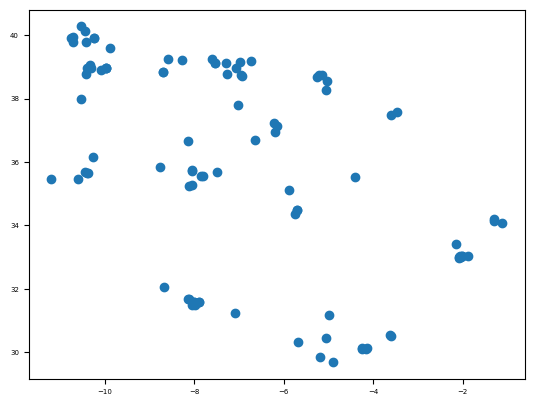

In [ ]:
plt.scatter(sorted_merged_df['latitude'], sorted_merged_df['longitude']);